In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
input_shape = (28, 28, 1)

In [4]:
def create_train_test_buckets(x_train, y_train, x_test, y_test):
    '''
    
    '''
    partitioned_train_arrays = {}
    numpy_partitioned_train_arrays = {}

    train_mix_fraction = 0.05
    test_mix_fraction = 0.05

    train_mix_length = int(len(x_train)*train_mix_fraction)
    test_mix_length = int(len(x_test)*test_mix_fraction)

    for item in zip(x_train,y_train):
        partitioned_train_arrays[item[1]]=([],[])

    for item in zip(x_train[:train_mix_length],y_train[:train_mix_length]):
        partitioned_train_arrays[item[1]][0].append(item[0])
        partitioned_train_arrays[item[1]][1].append(item[1])

    for item in zip(x_train[train_mix_length:],y_train[train_mix_length:]):
        random_bucket = int(np.random.randint(0,10,1))
        partitioned_train_arrays[random_bucket][0].append(item[0])
        partitioned_train_arrays[random_bucket][1].append(item[1])

    for item in partitioned_train_arrays:
        numpy_partitioned_train_arrays[item] = (np.array(partitioned_train_arrays[item][0]), np.array(partitioned_train_arrays[item][1]))

        
    partitioned_test_arrays = {}
    numpy_partitioned_test_arrays = {}


    for item in zip(x_test,y_test):
        partitioned_test_arrays[item[1]]=([],[])

    for item in zip(x_test[:test_mix_length],y_test[:test_mix_length]):
        partitioned_test_arrays[item[1]][0].append(item[0])
        partitioned_test_arrays[item[1]][1].append(item[1])

    for item in zip(x_test[test_mix_length:],y_test[test_mix_length:]):
        random_bucket = int(np.random.randint(0,10))
        partitioned_test_arrays[random_bucket][0].append(item[0])
        partitioned_test_arrays[random_bucket][1].append(item[1])


    for item in partitioned_test_arrays:
        partitioned_test_arrays[item] = (np.array(partitioned_test_arrays[item][0]), np.array(partitioned_test_arrays[item][1]))

    return(numpy_partitioned_train_arrays, partitioned_test_arrays)

In [5]:
partitioned_train_arrays, partitioned_test_arrays = create_train_test_buckets(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)


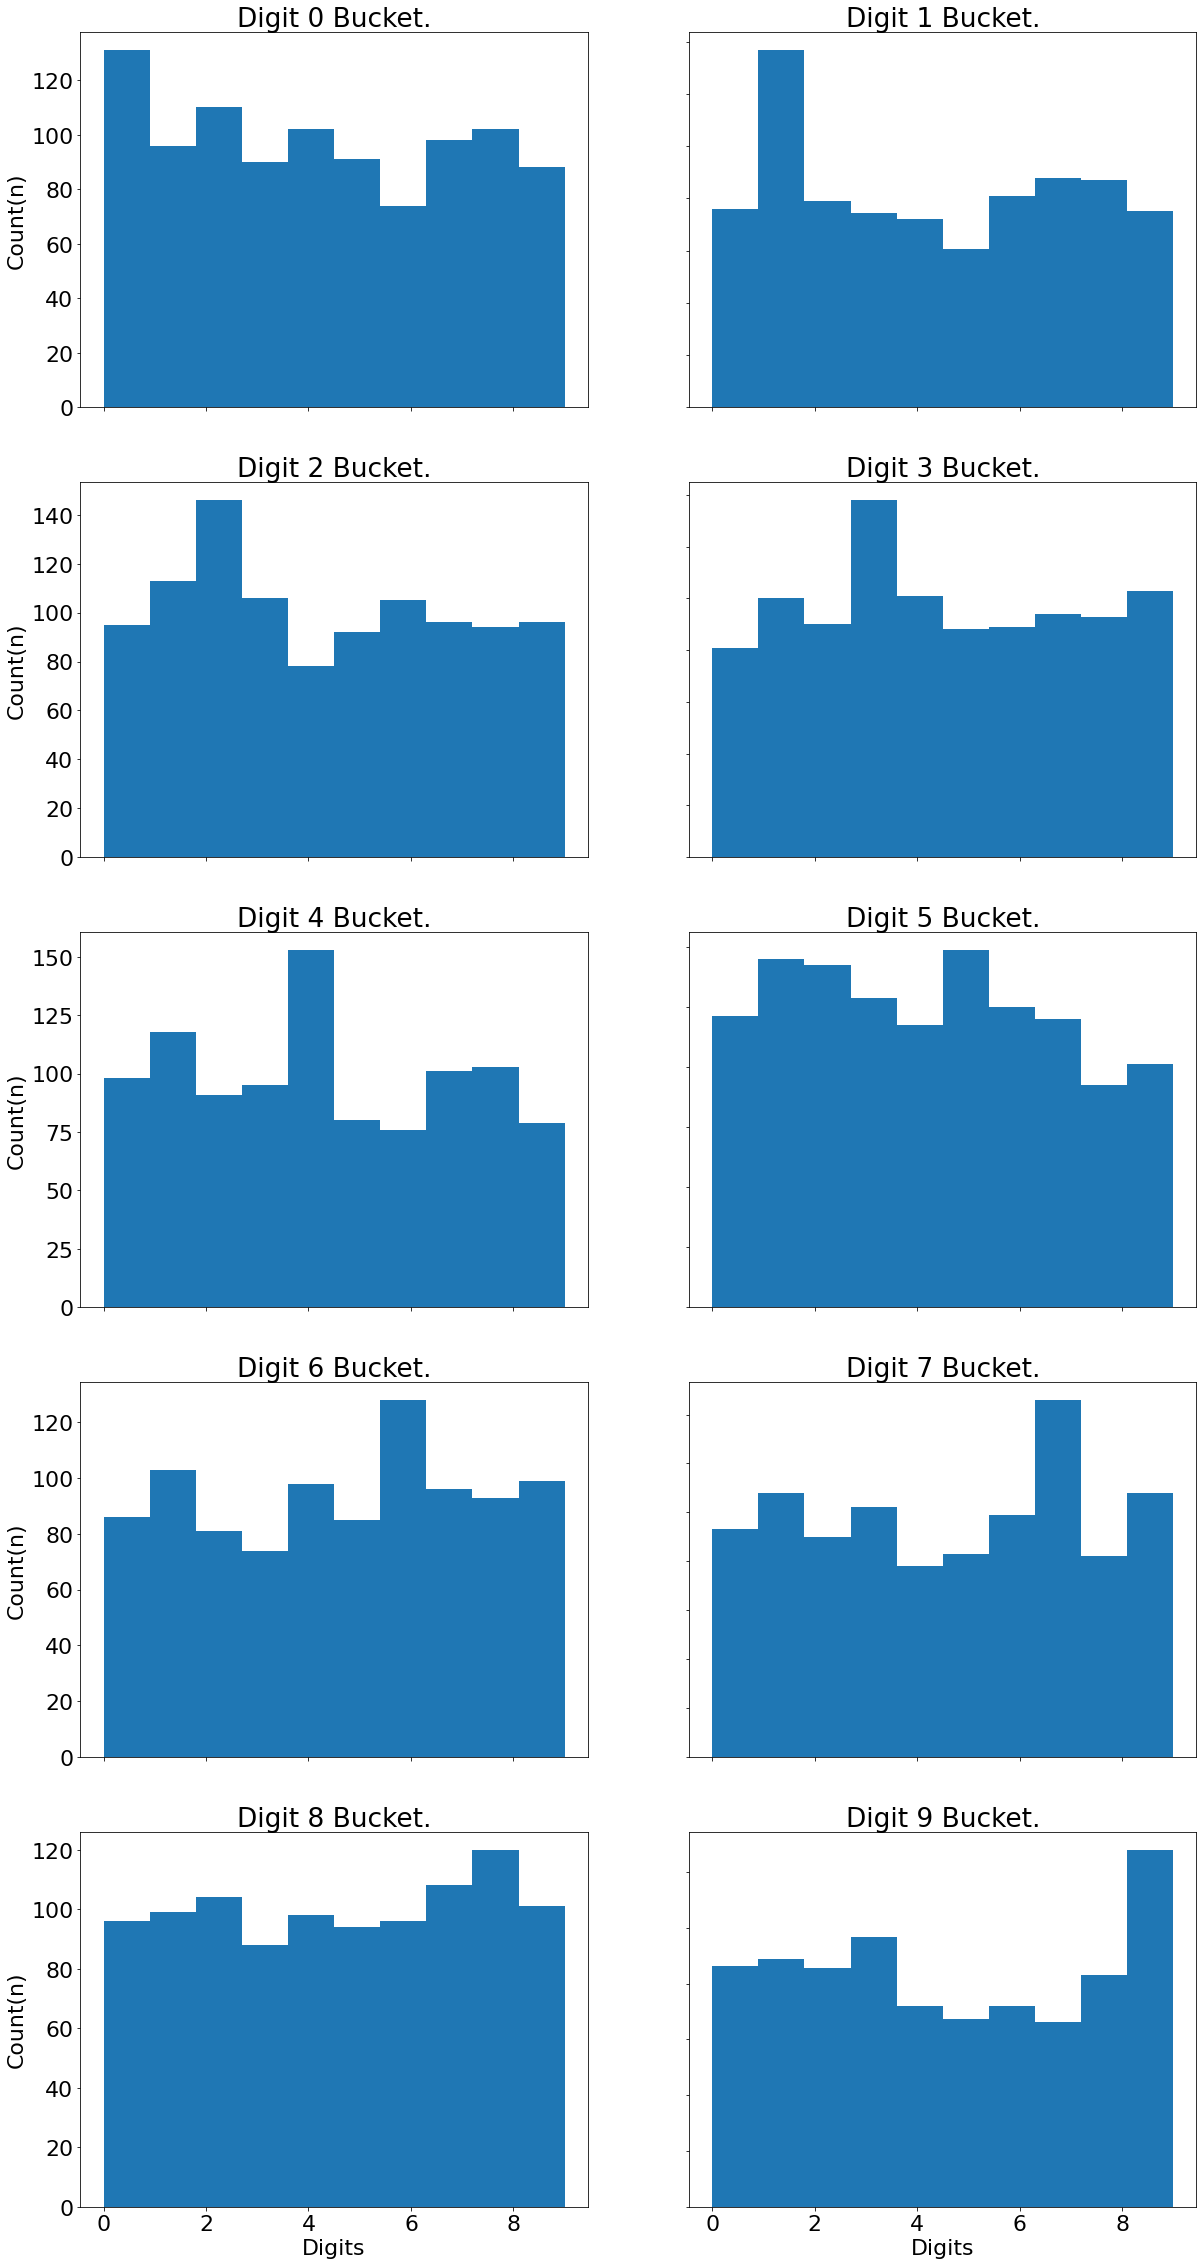

In [23]:
fig1, axs = plt.subplots(5,2, figsize=(20,40))
for row in range(5):
    for col in range(2):
        axs[row, col].hist(partitioned_test_arrays[row*2+col][1])
        axs[row, col].set_title('Digit {} Bucket.'.format(row*2+col))
        axs[row, col].set(xlabel='Digits', ylabel='Count(n)')

# axs[0, 0].hist(partitioned_test_arrays[0][1])
# axs[0, 1].hist(partitioned_test_arrays[1][1])
# axs[1, 0].hist(partitioned_test_arrays[2][1])
# axs[1, 1].hist(partitioned_test_arrays[3][1])
# axs[2, 0].hist(partitioned_test_arrays[4][1])
# axs[2, 1].hist(partitioned_test_arrays[5][1])
# axs[3, 0].hist(partitioned_test_arrays[6][1])
# axs[3, 1].hist(partitioned_test_arrays[7][1])
# axs[4, 0].hist(partitioned_test_arrays[8][1])
# axs[4, 1].hist(partitioned_test_arrays[9][1])

In [24]:
def create_keras_model():
    return tf.keras.models.Sequential([
        #tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(28, kernel_size=(5,5),input_shape=input_shape),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(14, kernel_size=(5,5)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(84,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

'numpy_partitioned_train_arrays' is dictionary with 10 keys corresponding to 0,1, ..., 9 digits.

##### Create a global model

In [36]:
model_global = create_keras_model()
model_global.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
print('total model layers', np.shape(model_global.layers))

total model layers (10,)


In [37]:
models_collection = {}
for item in range(10):
    models_collection['model_{}'.format(item)] = model_global

In [38]:
models_collection

{'model_0': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f9260df2278>,
 'model_1': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f9260df2278>,
 'model_2': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f9260df2278>,
 'model_3': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f9260df2278>,
 'model_4': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f9260df2278>,
 'model_5': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f9260df2278>,
 'model_6': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f9260df2278>,
 'model_7': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f9260df2278>,
 'model_8': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f9260df2278>,
 'model_9': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f9260df2278>}

#### Create random sets of training data and train them models for them

In [39]:
def local_train(model, model_index, partitioned_train_arrays, partitioned_test_arrays, x_test, y_test, train_sample_count=100):
    x_train_reshaped = partitioned_train_arrays[model_index][0].reshape(-1,28,28,1)
    y_train_reshaped = partitioned_train_arrays[model_index][1]

    random_rows = np.random.choice(x_train_reshaped.shape[0], train_sample_count, replace=False)

    x_train_partitioned = x_train_reshaped[random_rows,:]
    y_train_partitioned = y_train_reshaped[random_rows]
    model.fit(x=x_train_partitioned, y=y_train_partitioned, epochs=1)
    
    x_test_partitioned = partitioned_test_arrays[model_index][0].reshape(-1,28,28,1)
    y_test_partitioned = partitioned_test_arrays[model_index][1]
    
    train_accuracy = model.evaluate(x_train_partitioned, y_train_partitioned)
    local_test_acciracy = model.evaluate(x_test_partitioned.reshape(-1,28,28,1), y_test_partitioned)
    global_test_accuracy = model.evaluate(x_test.reshape(-1,28,28,1), y_test)
    
    print('Accuracies: Training={}, Local Test={}, Global Test={}'.format(train_accuracy[1], local_test_acciracy[1], global_test_accuracy[1]))
    return(model, train_accuracy, local_test_acciracy, global_test_accuracy)
    

In [40]:
def average_models_weights(models_collection):
    '''
    '''
    
    weights = [models_collection[model].get_weights() for model in models_collection]

    new_weights = np.array(weights).mean(axis=0)

    new_model = create_keras_model()
    new_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    new_model.set_weights(new_weights)
    
    return(new_model)

In [41]:
training_round = 50
training_round_accuracies = []
train_sample_count= 10
for iteration in range(training_round):
    print('Starting iteration: {}'.format(iteration))

    models_accuracies = []
    for model in models_collection:
        results = local_train(model=models_collection[model],
                        model_index=int(model.strip('model_')),
                        partitioned_train_arrays=partitioned_train_arrays,
                        partitioned_test_arrays=partitioned_test_arrays,
                        x_test = x_test,
                        y_test = y_test,
                        train_sample_count=train_sample_count)
        models_collection[model] = results[0]
        model_accuracies = [results[1][1], results[2][1], results[3][1]]
        models_accuracies.append(model_accuracies)

    training_round_accuracies.append(models_accuracies)
    print('Averaging Models')
    
    if(iteration<20):
        model_global = average_models_weights(models_collection)
        model_global.compile(optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
        print('total model layers', np.shape(model_global.layers))

        models_collection = {}
        for item in range(10):
            models_collection['model_{}'.format(item)] = model_global
    else:
        pass
    
    print('Finieshed iteration: {}'.format(iteration))
    
    

Starting iteration: 0
313/313 [==============================] - 3s 8ms/step - loss: 45.9616 - accuracy: 0.1117
Accuracies: Training=0.20000000298023224, Local Test=0.11303462088108063, Global Test=0.11169999837875366
313/313 [==============================] - 2s 7ms/step - loss: 30.8859 - accuracy: 0.1231
Accuracies: Training=0.0, Local Test=0.12716762721538544, Global Test=0.12309999763965607
313/313 [==============================] - 3s 9ms/step - loss: 21.4113 - accuracy: 0.1398
Accuracies: Training=0.20000000298023224, Local Test=0.16258570551872253, Global Test=0.13979999721050262
313/313 [==============================] - 2s 7ms/step - loss: 20.3468 - accuracy: 0.1376
Accuracies: Training=0.30000001192092896, Local Test=0.13203684985637665, Global Test=0.13760000467300415
313/313 [==============================] - 2s 7ms/step - loss: 18.6398 - accuracy: 0.1468
Accuracies: Training=0.0, Local Test=0.1327967792749405, Global Test=0.1467999964952469
313/313 [=======================

313/313 [==============================] - 2s 7ms/step - loss: 6.2590 - accuracy: 0.3557
Accuracies: Training=0.6000000238418579, Local Test=0.32071712613105774, Global Test=0.35569998621940613
313/313 [==============================] - 2s 8ms/step - loss: 5.7534 - accuracy: 0.3743
Accuracies: Training=0.20000000298023224, Local Test=0.40170133113861084, Global Test=0.3743000030517578
Averaging Models
total model layers (10,)
Finieshed iteration: 1
Starting iteration: 2
313/313 [==============================] - 2s 7ms/step - loss: 5.3429 - accuracy: 0.3654
Accuracies: Training=0.4000000059604645, Local Test=0.3655804395675659, Global Test=0.3653999865055084
313/313 [==============================] - 2s 8ms/step - loss: 6.0402 - accuracy: 0.3261
Accuracies: Training=0.10000000149011612, Local Test=0.35260117053985596, Global Test=0.3260999917984009
313/313 [==============================] - 2s 8ms/step - loss: 5.3955 - accuracy: 0.3561
Accuracies: Training=0.4000000059604645, Local Tes

313/313 [==============================] - 3s 9ms/step - loss: 4.0684 - accuracy: 0.5167
Accuracies: Training=0.30000001192092896, Local Test=0.5005302429199219, Global Test=0.516700029373169
313/313 [==============================] - 3s 11ms/step - loss: 4.6929 - accuracy: 0.4908
Accuracies: Training=0.699999988079071, Local Test=0.48331648111343384, Global Test=0.49079999327659607
313/313 [==============================] - 4s 14ms/step - loss: 5.0831 - accuracy: 0.4836
Accuracies: Training=0.699999988079071, Local Test=0.4681274890899658, Global Test=0.483599990606308
313/313 [==============================] - 3s 10ms/step - loss: 5.1881 - accuracy: 0.4802
Accuracies: Training=0.5, Local Test=0.4536862075328827, Global Test=0.48019999265670776
Averaging Models
total model layers (10,)
Finieshed iteration: 3
Starting iteration: 4
313/313 [==============================] - 3s 8ms/step - loss: 6.8823 - accuracy: 0.4253
Accuracies: Training=0.699999988079071, Local Test=0.432790219783782

313/313 [==============================] - 5s 16ms/step - loss: 6.7231 - accuracy: 0.4344
Accuracies: Training=0.30000001192092896, Local Test=0.4185110628604889, Global Test=0.4343999922275543
313/313 [==============================] - 7s 23ms/step - loss: 6.5610 - accuracy: 0.4536
Accuracies: Training=0.6000000238418579, Local Test=0.44064387679100037, Global Test=0.4535999894142151
313/313 [==============================] - 7s 22ms/step - loss: 5.8985 - accuracy: 0.4749
Accuracies: Training=0.30000001192092896, Local Test=0.4878048896789551, Global Test=0.4749000072479248
313/313 [==============================] - 7s 23ms/step - loss: 5.2032 - accuracy: 0.5034
Accuracies: Training=0.4000000059604645, Local Test=0.5075834393501282, Global Test=0.5034000277519226
313/313 [==============================] - 3s 9ms/step - loss: 4.5613 - accuracy: 0.5300
Accuracies: Training=0.699999988079071, Local Test=0.4910358488559723, Global Test=0.5299999713897705
313/313 [=========================

313/313 [==============================] - 2s 7ms/step - loss: 4.2054 - accuracy: 0.5241
Accuracies: Training=0.699999988079071, Local Test=0.5083251595497131, Global Test=0.5241000056266785
313/313 [==============================] - 2s 7ms/step - loss: 3.9744 - accuracy: 0.5311
Accuracies: Training=0.699999988079071, Local Test=0.5373592376708984, Global Test=0.5310999751091003
313/313 [==============================] - 3s 10ms/step - loss: 3.5363 - accuracy: 0.5421
Accuracies: Training=0.699999988079071, Local Test=0.5472837090492249, Global Test=0.5421000123023987
313/313 [==============================] - 3s 10ms/step - loss: 3.3072 - accuracy: 0.5481
Accuracies: Training=0.6000000238418579, Local Test=0.5271629691123962, Global Test=0.5480999946594238
313/313 [==============================] - 3s 9ms/step - loss: 3.1762 - accuracy: 0.5444
Accuracies: Training=0.699999988079071, Local Test=0.5312831401824951, Global Test=0.5443999767303467
313/313 [==============================] -

313/313 [==============================] - 3s 10ms/step - loss: 3.4843 - accuracy: 0.5036
Accuracies: Training=0.699999988079071, Local Test=0.5112016201019287, Global Test=0.503600001335144
313/313 [==============================] - 2s 7ms/step - loss: 2.9117 - accuracy: 0.5515
Accuracies: Training=0.5, Local Test=0.5847784280776978, Global Test=0.5515000224113464
313/313 [==============================] - 2s 8ms/step - loss: 2.8284 - accuracy: 0.5664
Accuracies: Training=0.8999999761581421, Local Test=0.5641527771949768, Global Test=0.5663999915122986
313/313 [==============================] - 2s 7ms/step - loss: 2.9667 - accuracy: 0.5578
Accuracies: Training=0.699999988079071, Local Test=0.5557830333709717, Global Test=0.5577999949455261
313/313 [==============================] - 3s 8ms/step - loss: 3.0774 - accuracy: 0.5433
Accuracies: Training=0.699999988079071, Local Test=0.5372233390808105, Global Test=0.5432999730110168
313/313 [==============================] - 3s 8ms/step - l

313/313 [==============================] - 4s 11ms/step - loss: 2.0685 - accuracy: 0.6225
Accuracies: Training=0.5, Local Test=0.607569694519043, Global Test=0.6225000023841858
313/313 [==============================] - 2s 6ms/step - loss: 2.3316 - accuracy: 0.5997
Accuracies: Training=0.6000000238418579, Local Test=0.5860113501548767, Global Test=0.5996999740600586
Averaging Models
total model layers (10,)
Finieshed iteration: 10
Starting iteration: 11
313/313 [==============================] - 3s 10ms/step - loss: 2.7539 - accuracy: 0.5571
Accuracies: Training=0.800000011920929, Local Test=0.5560081601142883, Global Test=0.5570999979972839
313/313 [==============================] - 2s 6ms/step - loss: 2.6429 - accuracy: 0.5608
Accuracies: Training=0.8999999761581421, Local Test=0.5539498925209045, Global Test=0.5608000159263611
313/313 [==============================] - 2s 6ms/step - loss: 2.2417 - accuracy: 0.5955
Accuracies: Training=0.800000011920929, Local Test=0.5994123220443726

313/313 [==============================] - 3s 10ms/step - loss: 1.8905 - accuracy: 0.6269
Accuracies: Training=0.8999999761581421, Local Test=0.6373276710510254, Global Test=0.6269000172615051
313/313 [==============================] - 3s 11ms/step - loss: 1.8907 - accuracy: 0.6280
Accuracies: Training=0.699999988079071, Local Test=0.6107178926467896, Global Test=0.628000020980835
313/313 [==============================] - 3s 10ms/step - loss: 1.8793 - accuracy: 0.6268
Accuracies: Training=0.800000011920929, Local Test=0.6195219159126282, Global Test=0.626800000667572
313/313 [==============================] - 3s 9ms/step - loss: 1.8512 - accuracy: 0.6291
Accuracies: Training=0.4000000059604645, Local Test=0.5982986688613892, Global Test=0.6291000247001648
Averaging Models
total model layers (10,)
Finieshed iteration: 12
Starting iteration: 13
313/313 [==============================] - 3s 9ms/step - loss: 2.0488 - accuracy: 0.6326
Accuracies: Training=1.0, Local Test=0.6344195604324341

313/313 [==============================] - 2s 7ms/step - loss: 1.9132 - accuracy: 0.6297
Accuracies: Training=0.6000000238418579, Local Test=0.6146881580352783, Global Test=0.6297000050544739
313/313 [==============================] - 2s 7ms/step - loss: 1.9540 - accuracy: 0.6295
Accuracies: Training=0.6000000238418579, Local Test=0.635814905166626, Global Test=0.6294999718666077
313/313 [==============================] - 2s 8ms/step - loss: 1.9485 - accuracy: 0.6344
Accuracies: Training=0.699999988079071, Local Test=0.630964994430542, Global Test=0.6344000101089478
313/313 [==============================] - 3s 9ms/step - loss: 1.9538 - accuracy: 0.6401
Accuracies: Training=1.0, Local Test=0.6329625844955444, Global Test=0.6401000022888184
313/313 [==============================] - 2s 7ms/step - loss: 1.9337 - accuracy: 0.6466
Accuracies: Training=0.800000011920929, Local Test=0.6474103331565857, Global Test=0.6466000080108643
313/313 [==============================] - 3s 9ms/step - lo

313/313 [==============================] - 2s 7ms/step - loss: 2.1754 - accuracy: 0.5880
Accuracies: Training=0.800000011920929, Local Test=0.5602350831031799, Global Test=0.5879999995231628
313/313 [==============================] - 2s 7ms/step - loss: 2.0072 - accuracy: 0.6038
Accuracies: Training=0.800000011920929, Local Test=0.6090071797370911, Global Test=0.6037999987602234
313/313 [==============================] - 3s 8ms/step - loss: 1.9167 - accuracy: 0.6167
Accuracies: Training=0.6000000238418579, Local Test=0.6267605423927307, Global Test=0.6166999936103821
313/313 [==============================] - 2s 6ms/step - loss: 1.9569 - accuracy: 0.6168
Accuracies: Training=0.800000011920929, Local Test=0.6076458692550659, Global Test=0.6168000102043152
313/313 [==============================] - 2s 7ms/step - loss: 1.9848 - accuracy: 0.6123
Accuracies: Training=0.699999988079071, Local Test=0.6320254802703857, Global Test=0.6122999787330627
313/313 [==============================] - 2

313/313 [==============================] - 2s 7ms/step - loss: 1.6467 - accuracy: 0.6588
Accuracies: Training=0.8999999761581421, Local Test=0.655804455280304, Global Test=0.6588000059127808
313/313 [==============================] - 2s 6ms/step - loss: 1.7231 - accuracy: 0.6518
Accuracies: Training=0.800000011920929, Local Test=0.6811175346374512, Global Test=0.6517999768257141
313/313 [==============================] - 2s 7ms/step - loss: 1.7969 - accuracy: 0.6374
Accuracies: Training=0.6000000238418579, Local Test=0.627815842628479, Global Test=0.6373999714851379
313/313 [==============================] - 3s 10ms/step - loss: 1.9779 - accuracy: 0.6087
Accuracies: Training=0.699999988079071, Local Test=0.5875127911567688, Global Test=0.6086999773979187
313/313 [==============================] - 2s 7ms/step - loss: 2.0231 - accuracy: 0.5887
Accuracies: Training=0.4000000059604645, Local Test=0.5814889073371887, Global Test=0.588699996471405
313/313 [==============================] - 2

313/313 [==============================] - 2s 7ms/step - loss: 1.6373 - accuracy: 0.6676
Accuracies: Training=0.6000000238418579, Local Test=0.6474103331565857, Global Test=0.6675999760627747
313/313 [==============================] - 2s 7ms/step - loss: 1.6619 - accuracy: 0.6662
Accuracies: Training=0.800000011920929, Local Test=0.6465028524398804, Global Test=0.6661999821662903
Averaging Models
total model layers (10,)
Finieshed iteration: 19
Starting iteration: 20
313/313 [==============================] - 2s 6ms/step - loss: 1.7268 - accuracy: 0.6424
Accuracies: Training=0.800000011920929, Local Test=0.6466395258903503, Global Test=0.6424000263214111
313/313 [==============================] - 2s 8ms/step - loss: 1.7132 - accuracy: 0.6307
Accuracies: Training=0.6000000238418579, Local Test=0.6416184902191162, Global Test=0.6306999921798706
313/313 [==============================] - 2s 7ms/step - loss: 1.7510 - accuracy: 0.6263
Accuracies: Training=0.6000000238418579, Local Test=0.61

313/313 [==============================] - 2s 7ms/step - loss: 1.9119 - accuracy: 0.6810
Accuracies: Training=0.5, Local Test=0.6797454953193665, Global Test=0.6809999942779541
313/313 [==============================] - 2s 6ms/step - loss: 1.9449 - accuracy: 0.6872
Accuracies: Training=0.800000011920929, Local Test=0.6996966600418091, Global Test=0.6872000098228455
313/313 [==============================] - 2s 7ms/step - loss: 1.9753 - accuracy: 0.6917
Accuracies: Training=0.8999999761581421, Local Test=0.6802788972854614, Global Test=0.6916999816894531
313/313 [==============================] - 2s 7ms/step - loss: 1.9437 - accuracy: 0.6981
Accuracies: Training=0.6000000238418579, Local Test=0.6880907416343689, Global Test=0.6980999708175659
Averaging Models
Finieshed iteration: 21
Starting iteration: 22
313/313 [==============================] - 2s 8ms/step - loss: 1.8802 - accuracy: 0.7043
Accuracies: Training=0.699999988079071, Local Test=0.7016293406486511, Global Test=0.7042999863

313/313 [==============================] - 2s 8ms/step - loss: 1.5884 - accuracy: 0.7233
Accuracies: Training=0.800000011920929, Local Test=0.7303823232650757, Global Test=0.7232999801635742
313/313 [==============================] - 2s 7ms/step - loss: 1.5535 - accuracy: 0.7251
Accuracies: Training=0.699999988079071, Local Test=0.7253521084785461, Global Test=0.7250999808311462
313/313 [==============================] - 2s 7ms/step - loss: 1.5232 - accuracy: 0.7280
Accuracies: Training=0.699999988079071, Local Test=0.7348886728286743, Global Test=0.7279999852180481
313/313 [==============================] - 2s 7ms/step - loss: 1.5071 - accuracy: 0.7317
Accuracies: Training=0.800000011920929, Local Test=0.739130437374115, Global Test=0.7317000031471252
313/313 [==============================] - 2s 6ms/step - loss: 1.4801 - accuracy: 0.7315
Accuracies: Training=0.6000000238418579, Local Test=0.724103569984436, Global Test=0.7315000295639038
313/313 [==============================] - 2s 

313/313 [==============================] - 2s 6ms/step - loss: 1.2146 - accuracy: 0.7390
Accuracies: Training=0.6000000238418579, Local Test=0.7267385125160217, Global Test=0.7390000224113464
313/313 [==============================] - 3s 8ms/step - loss: 1.1997 - accuracy: 0.7362
Accuracies: Training=0.5, Local Test=0.7277379631996155, Global Test=0.7361999750137329
313/313 [==============================] - 2s 7ms/step - loss: 1.2063 - accuracy: 0.7293
Accuracies: Training=0.6000000238418579, Local Test=0.7122736573219299, Global Test=0.7293000221252441
313/313 [==============================] - 2s 8ms/step - loss: 1.2071 - accuracy: 0.7238
Accuracies: Training=0.800000011920929, Local Test=0.7454728484153748, Global Test=0.723800003528595
313/313 [==============================] - 2s 7ms/step - loss: 1.2231 - accuracy: 0.7194
Accuracies: Training=0.8999999761581421, Local Test=0.7200424075126648, Global Test=0.7193999886512756
313/313 [==============================] - 2s 7ms/step - 

313/313 [==============================] - 2s 8ms/step - loss: 1.2081 - accuracy: 0.6816
Accuracies: Training=0.8999999761581421, Local Test=0.7087576389312744, Global Test=0.6815999746322632
313/313 [==============================] - 2s 7ms/step - loss: 1.1664 - accuracy: 0.6885
Accuracies: Training=0.5, Local Test=0.6965317726135254, Global Test=0.6884999871253967
313/313 [==============================] - 3s 9ms/step - loss: 1.1076 - accuracy: 0.6938
Accuracies: Training=0.8999999761581421, Local Test=0.6738491654396057, Global Test=0.6937999725341797
313/313 [==============================] - 2s 7ms/step - loss: 1.0627 - accuracy: 0.7043
Accuracies: Training=0.800000011920929, Local Test=0.6990787982940674, Global Test=0.7042999863624573
313/313 [==============================] - 2s 7ms/step - loss: 1.0471 - accuracy: 0.7083
Accuracies: Training=0.8999999761581421, Local Test=0.7062374353408813, Global Test=0.708299994468689
313/313 [==============================] - 3s 8ms/step - 

313/313 [==============================] - 2s 7ms/step - loss: 0.9958 - accuracy: 0.7526
Accuracies: Training=0.800000011920929, Local Test=0.7420318722724915, Global Test=0.7526000142097473
313/313 [==============================] - 2s 7ms/step - loss: 1.0107 - accuracy: 0.7500
Accuracies: Training=0.800000011920929, Local Test=0.7315689921379089, Global Test=0.75
Averaging Models
Finieshed iteration: 28
Starting iteration: 29
313/313 [==============================] - 4s 14ms/step - loss: 1.0303 - accuracy: 0.7490
Accuracies: Training=1.0, Local Test=0.7556008100509644, Global Test=0.7490000128746033
313/313 [==============================] - 5s 16ms/step - loss: 1.0465 - accuracy: 0.7476
Accuracies: Training=0.8999999761581421, Local Test=0.7485548853874207, Global Test=0.7476000189781189
313/313 [==============================] - 2s 8ms/step - loss: 1.0383 - accuracy: 0.7470
Accuracies: Training=0.8999999761581421, Local Test=0.7512242794036865, Global Test=0.746999979019165
313/31

313/313 [==============================] - 2s 7ms/step - loss: 0.8498 - accuracy: 0.7633
Accuracies: Training=0.800000011920929, Local Test=0.7794273495674133, Global Test=0.7633000016212463
313/313 [==============================] - 3s 8ms/step - loss: 0.8576 - accuracy: 0.7607
Accuracies: Training=0.699999988079071, Local Test=0.7694640755653381, Global Test=0.760699987411499
313/313 [==============================] - 3s 8ms/step - loss: 0.8685 - accuracy: 0.7579
Accuracies: Training=0.800000011920929, Local Test=0.7380478382110596, Global Test=0.7578999996185303
313/313 [==============================] - 2s 8ms/step - loss: 0.8895 - accuracy: 0.7556
Accuracies: Training=0.800000011920929, Local Test=0.724952757358551, Global Test=0.7555999755859375
Averaging Models
Finieshed iteration: 30
Starting iteration: 31
313/313 [==============================] - 2s 7ms/step - loss: 0.9177 - accuracy: 0.7504
Accuracies: Training=0.800000011920929, Local Test=0.7617108225822449, Global Test=0.

313/313 [==============================] - 2s 8ms/step - loss: 0.8486 - accuracy: 0.7895
Accuracies: Training=0.800000011920929, Local Test=0.772635817527771, Global Test=0.7894999980926514
313/313 [==============================] - 2s 7ms/step - loss: 0.8366 - accuracy: 0.7909
Accuracies: Training=0.800000011920929, Local Test=0.8078470826148987, Global Test=0.7908999919891357
313/313 [==============================] - 2s 8ms/step - loss: 0.8253 - accuracy: 0.7943
Accuracies: Training=0.699999988079071, Local Test=0.8027571439743042, Global Test=0.7943000197410583
313/313 [==============================] - 2s 8ms/step - loss: 0.8138 - accuracy: 0.7960
Accuracies: Training=0.800000011920929, Local Test=0.8028311133384705, Global Test=0.7960000038146973
313/313 [==============================] - 2s 7ms/step - loss: 0.8135 - accuracy: 0.7958
Accuracies: Training=1.0, Local Test=0.7858565449714661, Global Test=0.795799970626831
313/313 [==============================] - 2s 7ms/step - loss

313/313 [==============================] - 2s 7ms/step - loss: 0.8412 - accuracy: 0.7742
Accuracies: Training=0.6000000238418579, Local Test=0.7708129286766052, Global Test=0.7742000222206116
313/313 [==============================] - 4s 11ms/step - loss: 0.8382 - accuracy: 0.7734
Accuracies: Training=0.8999999761581421, Local Test=0.773797333240509, Global Test=0.7734000086784363
313/313 [==============================] - 3s 8ms/step - loss: 0.8299 - accuracy: 0.7714
Accuracies: Training=0.6000000238418579, Local Test=0.7746478915214539, Global Test=0.771399974822998
313/313 [==============================] - 4s 13ms/step - loss: 0.8313 - accuracy: 0.7661
Accuracies: Training=1.0, Local Test=0.7605633735656738, Global Test=0.7660999894142151
313/313 [==============================] - 4s 14ms/step - loss: 0.8403 - accuracy: 0.7592
Accuracies: Training=0.800000011920929, Local Test=0.7613998055458069, Global Test=0.7591999769210815
313/313 [==============================] - 2s 8ms/step 

313/313 [==============================] - 2s 7ms/step - loss: 0.8625 - accuracy: 0.7569
Accuracies: Training=0.699999988079071, Local Test=0.7688391208648682, Global Test=0.7569000124931335
313/313 [==============================] - 2s 8ms/step - loss: 0.8406 - accuracy: 0.7622
Accuracies: Training=0.6000000238418579, Local Test=0.7601156234741211, Global Test=0.7621999979019165
313/313 [==============================] - 3s 11ms/step - loss: 0.8278 - accuracy: 0.7651
Accuracies: Training=0.800000011920929, Local Test=0.759059727191925, Global Test=0.7651000022888184
313/313 [==============================] - 2s 8ms/step - loss: 0.8315 - accuracy: 0.7659
Accuracies: Training=0.699999988079071, Local Test=0.7594677805900574, Global Test=0.7659000158309937
313/313 [==============================] - 3s 8ms/step - loss: 0.8424 - accuracy: 0.7665
Accuracies: Training=0.6000000238418579, Local Test=0.7786720395088196, Global Test=0.7664999961853027
313/313 [==============================] - 

313/313 [==============================] - 4s 12ms/step - loss: 0.9627 - accuracy: 0.7372
Accuracies: Training=0.699999988079071, Local Test=0.7360557913780212, Global Test=0.7372000217437744
313/313 [==============================] - 3s 8ms/step - loss: 0.9320 - accuracy: 0.7436
Accuracies: Training=0.4000000059604645, Local Test=0.721172034740448, Global Test=0.7436000108718872
Averaging Models
Finieshed iteration: 37
Starting iteration: 38
313/313 [==============================] - 3s 9ms/step - loss: 0.8997 - accuracy: 0.7472
Accuracies: Training=0.8999999761581421, Local Test=0.7505091428756714, Global Test=0.7472000122070312
313/313 [==============================] - 2s 8ms/step - loss: 0.8607 - accuracy: 0.7534
Accuracies: Training=0.800000011920929, Local Test=0.7427745461463928, Global Test=0.7534000277519226
313/313 [==============================] - 2s 7ms/step - loss: 0.8284 - accuracy: 0.7559
Accuracies: Training=0.6000000238418579, Local Test=0.754162609577179, Global Tes

313/313 [==============================] - 2s 8ms/step - loss: 0.9186 - accuracy: 0.7215
Accuracies: Training=0.800000011920929, Local Test=0.7274655103683472, Global Test=0.7214999794960022
313/313 [==============================] - 5s 15ms/step - loss: 0.9165 - accuracy: 0.7251
Accuracies: Training=0.6000000238418579, Local Test=0.7340748310089111, Global Test=0.7250999808311462
313/313 [==============================] - 3s 9ms/step - loss: 0.9000 - accuracy: 0.7310
Accuracies: Training=0.8999999761581421, Local Test=0.7320716977119446, Global Test=0.7310000061988831
313/313 [==============================] - 3s 9ms/step - loss: 0.8829 - accuracy: 0.7345
Accuracies: Training=0.8999999761581421, Local Test=0.7041587829589844, Global Test=0.734499990940094
Averaging Models
Finieshed iteration: 39
Starting iteration: 40
313/313 [==============================] - 2s 7ms/step - loss: 0.8774 - accuracy: 0.7341
Accuracies: Training=0.5, Local Test=0.7494908571243286, Global Test=0.734099984

313/313 [==============================] - 3s 9ms/step - loss: 0.9911 - accuracy: 0.7247
Accuracies: Training=0.800000011920929, Local Test=0.7112675905227661, Global Test=0.7246999740600586
313/313 [==============================] - 3s 10ms/step - loss: 0.9508 - accuracy: 0.7293
Accuracies: Training=0.6000000238418579, Local Test=0.7223340272903442, Global Test=0.7293000221252441
313/313 [==============================] - 3s 10ms/step - loss: 0.9205 - accuracy: 0.7319
Accuracies: Training=0.699999988079071, Local Test=0.7518557906150818, Global Test=0.7318999767303467
313/313 [==============================] - 2s 8ms/step - loss: 0.9016 - accuracy: 0.7344
Accuracies: Training=0.699999988079071, Local Test=0.7249747514724731, Global Test=0.7343999743461609
313/313 [==============================] - 2s 7ms/step - loss: 0.8889 - accuracy: 0.7359
Accuracies: Training=0.699999988079071, Local Test=0.7260956168174744, Global Test=0.7358999848365784
313/313 [==============================] -

313/313 [==============================] - 3s 11ms/step - loss: 0.7419 - accuracy: 0.7730
Accuracies: Training=0.8999999761581421, Local Test=0.7708129286766052, Global Test=0.7730000019073486
313/313 [==============================] - 2s 8ms/step - loss: 0.7347 - accuracy: 0.7762
Accuracies: Training=0.5, Local Test=0.7625383734703064, Global Test=0.776199996471405
313/313 [==============================] - 3s 10ms/step - loss: 0.7257 - accuracy: 0.7796
Accuracies: Training=0.8999999761581421, Local Test=0.7776659727096558, Global Test=0.7796000242233276
313/313 [==============================] - 2s 7ms/step - loss: 0.7090 - accuracy: 0.7829
Accuracies: Training=0.800000011920929, Local Test=0.7655935883522034, Global Test=0.7828999757766724
313/313 [==============================] - 3s 10ms/step - loss: 0.7005 - accuracy: 0.7839
Accuracies: Training=0.800000011920929, Local Test=0.8048780560493469, Global Test=0.7839000225067139
313/313 [==============================] - 2s 7ms/step 

313/313 [==============================] - 3s 8ms/step - loss: 0.6291 - accuracy: 0.8047
Accuracies: Training=0.699999988079071, Local Test=0.8146639466285706, Global Test=0.8047000169754028
313/313 [==============================] - 4s 13ms/step - loss: 0.6268 - accuracy: 0.8059
Accuracies: Training=1.0, Local Test=0.8111753463745117, Global Test=0.805899977684021
313/313 [==============================] - 2s 8ms/step - loss: 0.6265 - accuracy: 0.8070
Accuracies: Training=0.800000011920929, Local Test=0.8158667683601379, Global Test=0.8069999814033508
313/313 [==============================] - 3s 9ms/step - loss: 0.6285 - accuracy: 0.8050
Accuracies: Training=0.8999999761581421, Local Test=0.8014329671859741, Global Test=0.8050000071525574
313/313 [==============================] - 3s 11ms/step - loss: 0.6283 - accuracy: 0.8055
Accuracies: Training=0.6000000238418579, Local Test=0.7877263426780701, Global Test=0.8054999709129333
313/313 [==============================] - 3s 9ms/step -

313/313 [==============================] - 2s 7ms/step - loss: 0.6278 - accuracy: 0.8092
Accuracies: Training=1.0, Local Test=0.8017928004264832, Global Test=0.8091999888420105
313/313 [==============================] - 3s 11ms/step - loss: 0.6297 - accuracy: 0.8116
Accuracies: Training=0.800000011920929, Local Test=0.7977315783500671, Global Test=0.8116000294685364
Averaging Models
Finieshed iteration: 46
Starting iteration: 47
313/313 [==============================] - 2s 7ms/step - loss: 0.6341 - accuracy: 0.8111
Accuracies: Training=0.8999999761581421, Local Test=0.813645601272583, Global Test=0.8111000061035156
313/313 [==============================] - 2s 8ms/step - loss: 0.6344 - accuracy: 0.8112
Accuracies: Training=0.800000011920929, Local Test=0.8121387362480164, Global Test=0.8112000226974487
313/313 [==============================] - 2s 7ms/step - loss: 0.6357 - accuracy: 0.8125
Accuracies: Training=0.8999999761581421, Local Test=0.8276199698448181, Global Test=0.8125
313/3

313/313 [==============================] - 3s 10ms/step - loss: 0.6723 - accuracy: 0.8065
Accuracies: Training=0.8999999761581421, Local Test=0.7963944673538208, Global Test=0.8065000176429749
313/313 [==============================] - 3s 8ms/step - loss: 0.6685 - accuracy: 0.8046
Accuracies: Training=0.699999988079071, Local Test=0.8109201192855835, Global Test=0.8046000003814697
313/313 [==============================] - 3s 8ms/step - loss: 0.6667 - accuracy: 0.8027
Accuracies: Training=1.0, Local Test=0.791832685470581, Global Test=0.8026999831199646
313/313 [==============================] - 3s 9ms/step - loss: 0.6701 - accuracy: 0.8030
Accuracies: Training=0.8999999761581421, Local Test=0.793005645275116, Global Test=0.8029999732971191
Averaging Models
Finieshed iteration: 48
Starting iteration: 49
313/313 [==============================] - 2s 8ms/step - loss: 0.6861 - accuracy: 0.7996
Accuracies: Training=0.800000011920929, Local Test=0.7983706593513489, Global Test=0.79960000514

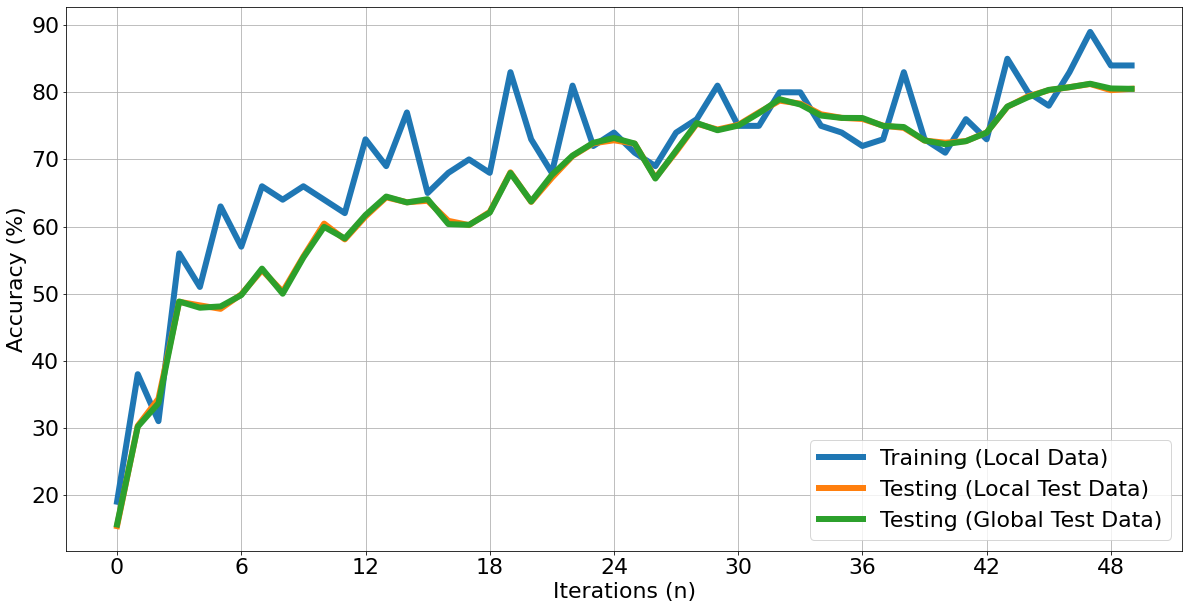

In [42]:
fig2, ax1 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.array(training_round_accuracies).mean(axis=1)*100, linewidth=6)
plt.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Iterations (n)')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(('Training (Local Data)', 'Testing (Local Test Data)', 'Testing (Global Test Data)'))



In [43]:
model_global = create_keras_model()
model_global.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
print('total model layers', np.shape(model_global.layers))

models_collection = {}
for item in range(10):
    models_collection['model_{}'.format(item)] = model_global


training_round = 50
training_round_accuracies_finetune = []
train_sample_count=100
for iteration in range(training_round):
    print('Starting iteration: {}'.format(iteration))

    models_accuracies = []
    for model in models_collection:
        results = local_train(model=models_collection[model],
                        model_index=int(model.strip('model_')),
                        partitioned_train_arrays=partitioned_train_arrays,
                        partitioned_test_arrays=partitioned_test_arrays,
                        x_test = x_test,
                        y_test = y_test,
                        train_sample_count=train_sample_count)
        models_collection[model] = results[0]
        model_accuracies = [results[1][1], results[2][1], results[3][1]]
        models_accuracies.append(model_accuracies)

    training_round_accuracies_finetune.append(models_accuracies)
    print('Averaging Models')
    
    if(iteration<20):
        model_global = average_models_weights(models_collection)
        model_global.compile(optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
        print('total model layers', np.shape(model_global.layers))

        models_collection = {}
        for item in range(10):
            models_collection['model_{}'.format(item)] = model_global
    else:
        pass
    
    print('Finieshed iteration: {}'.format(iteration))
    
    

total model layers (10,)
Starting iteration: 0
313/313 [==============================] - 3s 8ms/step - loss: 16.9487 - accuracy: 0.1474
Accuracies: Training=0.15000000596046448, Local Test=0.1496945023536682, Global Test=0.14740000665187836
313/313 [==============================] - 2s 8ms/step - loss: 13.9427 - accuracy: 0.3197
Accuracies: Training=0.3199999928474426, Local Test=0.31695568561553955, Global Test=0.3197000026702881
313/313 [==============================] - 2s 7ms/step - loss: 11.7017 - accuracy: 0.3134
Accuracies: Training=0.23999999463558197, Local Test=0.3016650378704071, Global Test=0.313400000333786
313/313 [==============================] - 2s 7ms/step - loss: 6.2418 - accuracy: 0.3867
Accuracies: Training=0.4099999964237213, Local Test=0.39918115735054016, Global Test=0.38670000433921814
313/313 [==============================] - 3s 9ms/step - loss: 5.0793 - accuracy: 0.4078
Accuracies: Training=0.38999998569488525, Local Test=0.39839035272598267, Global Test=0.

313/313 [==============================] - 2s 7ms/step - loss: 1.9397 - accuracy: 0.6627
Accuracies: Training=0.6800000071525574, Local Test=0.6723107695579529, Global Test=0.6626999974250793
313/313 [==============================] - 2s 7ms/step - loss: 2.2620 - accuracy: 0.6198
Accuracies: Training=0.6899999976158142, Local Test=0.6001890301704407, Global Test=0.6197999715805054
Averaging Models
total model layers (10,)
Finieshed iteration: 1
Starting iteration: 2
313/313 [==============================] - 2s 8ms/step - loss: 2.3613 - accuracy: 0.6301
Accuracies: Training=0.8299999833106995, Local Test=0.6496945023536682, Global Test=0.6301000118255615
313/313 [==============================] - 3s 9ms/step - loss: 2.0608 - accuracy: 0.6832
Accuracies: Training=0.8299999833106995, Local Test=0.7052023410797119, Global Test=0.6832000017166138
313/313 [==============================] - 3s 9ms/step - loss: 1.7751 - accuracy: 0.7071
Accuracies: Training=0.7400000095367432, Local Test=0.71

313/313 [==============================] - 2s 7ms/step - loss: 0.9973 - accuracy: 0.7476
Accuracies: Training=0.8100000023841858, Local Test=0.7582184672355652, Global Test=0.7476000189781189
313/313 [==============================] - 3s 10ms/step - loss: 0.9307 - accuracy: 0.7577
Accuracies: Training=0.7900000214576721, Local Test=0.7583417296409607, Global Test=0.7577000260353088
313/313 [==============================] - 3s 9ms/step - loss: 1.0009 - accuracy: 0.7481
Accuracies: Training=0.7799999713897705, Local Test=0.7450199127197266, Global Test=0.7480999827384949
313/313 [==============================] - 2s 7ms/step - loss: 1.0959 - accuracy: 0.7365
Accuracies: Training=0.7799999713897705, Local Test=0.7098298668861389, Global Test=0.7365000247955322
Averaging Models
total model layers (10,)
Finieshed iteration: 3
Starting iteration: 4
313/313 [==============================] - 3s 9ms/step - loss: 1.2821 - accuracy: 0.7256
Accuracies: Training=0.8100000023841858, Local Test=0.7

313/313 [==============================] - 2s 7ms/step - loss: 0.8361 - accuracy: 0.7932
Accuracies: Training=0.8600000143051147, Local Test=0.786720335483551, Global Test=0.7932000160217285
313/313 [==============================] - 3s 8ms/step - loss: 0.8085 - accuracy: 0.7997
Accuracies: Training=0.8100000023841858, Local Test=0.786720335483551, Global Test=0.7997000217437744
313/313 [==============================] - 3s 10ms/step - loss: 0.7954 - accuracy: 0.7941
Accuracies: Training=0.8299999833106995, Local Test=0.8091198205947876, Global Test=0.7940999865531921
313/313 [==============================] - 3s 10ms/step - loss: 0.8170 - accuracy: 0.7825
Accuracies: Training=0.7799999713897705, Local Test=0.7846309542655945, Global Test=0.7825000286102295
313/313 [==============================] - 3s 9ms/step - loss: 0.7924 - accuracy: 0.7889
Accuracies: Training=0.8299999833106995, Local Test=0.791832685470581, Global Test=0.7889000177383423
313/313 [==============================] 

313/313 [==============================] - 2s 7ms/step - loss: 0.6933 - accuracy: 0.8157
Accuracies: Training=0.8700000047683716, Local Test=0.821743369102478, Global Test=0.8156999945640564
313/313 [==============================] - 2s 7ms/step - loss: 0.6146 - accuracy: 0.8365
Accuracies: Training=0.8899999856948853, Local Test=0.837256908416748, Global Test=0.8364999890327454
313/313 [==============================] - 2s 7ms/step - loss: 0.6318 - accuracy: 0.8290
Accuracies: Training=0.8899999856948853, Local Test=0.8279678225517273, Global Test=0.8289999961853027
313/313 [==============================] - 2s 7ms/step - loss: 0.6542 - accuracy: 0.8198
Accuracies: Training=0.8700000047683716, Local Test=0.8118712306022644, Global Test=0.8198000192642212
313/313 [==============================] - 2s 7ms/step - loss: 0.7401 - accuracy: 0.8082
Accuracies: Training=0.8500000238418579, Local Test=0.8091198205947876, Global Test=0.8082000017166138
313/313 [==============================] -

total model layers (10,)
Finieshed iteration: 8
Starting iteration: 9
313/313 [==============================] - 3s 10ms/step - loss: 0.6618 - accuracy: 0.8257
Accuracies: Training=0.8500000238418579, Local Test=0.844195544719696, Global Test=0.8256999850273132
313/313 [==============================] - 2s 7ms/step - loss: 0.6604 - accuracy: 0.8207
Accuracies: Training=0.8600000143051147, Local Test=0.8227360248565674, Global Test=0.8206999897956848
313/313 [==============================] - 2s 7ms/step - loss: 0.6629 - accuracy: 0.8326
Accuracies: Training=0.8299999833106995, Local Test=0.832517147064209, Global Test=0.8325999975204468
313/313 [==============================] - 3s 10ms/step - loss: 0.6243 - accuracy: 0.8399
Accuracies: Training=0.8600000143051147, Local Test=0.8331627249717712, Global Test=0.839900016784668
313/313 [==============================] - 2s 8ms/step - loss: 0.6722 - accuracy: 0.8289
Accuracies: Training=0.8799999952316284, Local Test=0.8289738297462463, Gl

313/313 [==============================] - 2s 7ms/step - loss: 0.4766 - accuracy: 0.8619
Accuracies: Training=0.8799999952316284, Local Test=0.850597620010376, Global Test=0.8618999719619751
313/313 [==============================] - 3s 9ms/step - loss: 0.4559 - accuracy: 0.8729
Accuracies: Training=0.9200000166893005, Local Test=0.8459357023239136, Global Test=0.8729000091552734
Averaging Models
total model layers (10,)
Finieshed iteration: 10
Starting iteration: 11
313/313 [==============================] - 4s 13ms/step - loss: 0.5745 - accuracy: 0.8324
Accuracies: Training=0.9100000262260437, Local Test=0.837067186832428, Global Test=0.8324000239372253
313/313 [==============================] - 3s 9ms/step - loss: 0.7714 - accuracy: 0.8074
Accuracies: Training=0.8399999737739563, Local Test=0.8198458552360535, Global Test=0.8073999881744385
313/313 [==============================] - 2s 7ms/step - loss: 0.6044 - accuracy: 0.8490
Accuracies: Training=0.8899999856948853, Local Test=0.8

313/313 [==============================] - 3s 8ms/step - loss: 0.5261 - accuracy: 0.8837
Accuracies: Training=0.8799999952316284, Local Test=0.889713704586029, Global Test=0.8837000131607056
313/313 [==============================] - 2s 7ms/step - loss: 0.5020 - accuracy: 0.8923
Accuracies: Training=0.9300000071525574, Local Test=0.8877654075622559, Global Test=0.892300009727478
313/313 [==============================] - 2s 7ms/step - loss: 0.5379 - accuracy: 0.8799
Accuracies: Training=0.9300000071525574, Local Test=0.8774900436401367, Global Test=0.8798999786376953
313/313 [==============================] - 2s 8ms/step - loss: 0.5876 - accuracy: 0.8666
Accuracies: Training=0.8999999761581421, Local Test=0.8431001901626587, Global Test=0.866599977016449
Averaging Models
total model layers (10,)
Finieshed iteration: 12
Starting iteration: 13
313/313 [==============================] - 2s 7ms/step - loss: 0.5122 - accuracy: 0.8912
Accuracies: Training=0.949999988079071, Local Test=0.9063

313/313 [==============================] - 2s 7ms/step - loss: 0.5785 - accuracy: 0.8614
Accuracies: Training=0.8799999952316284, Local Test=0.8597748279571533, Global Test=0.8614000082015991
313/313 [==============================] - 2s 8ms/step - loss: 0.5651 - accuracy: 0.8592
Accuracies: Training=0.8700000047683716, Local Test=0.8722333908081055, Global Test=0.8592000007629395
313/313 [==============================] - 2s 7ms/step - loss: 0.5454 - accuracy: 0.8650
Accuracies: Training=0.8999999761581421, Local Test=0.850100576877594, Global Test=0.8650000095367432
313/313 [==============================] - 2s 7ms/step - loss: 0.5457 - accuracy: 0.8586
Accuracies: Training=0.8799999952316284, Local Test=0.8536585569381714, Global Test=0.8586000204086304
313/313 [==============================] - 2s 7ms/step - loss: 0.5712 - accuracy: 0.8513
Accuracies: Training=0.8100000023841858, Local Test=0.8442871570587158, Global Test=0.8513000011444092
313/313 [==============================] 

313/313 [==============================] - 2s 7ms/step - loss: 0.4357 - accuracy: 0.8892
Accuracies: Training=0.8999999761581421, Local Test=0.8882466554641724, Global Test=0.88919997215271
313/313 [==============================] - 2s 7ms/step - loss: 0.4479 - accuracy: 0.8875
Accuracies: Training=0.949999988079071, Local Test=0.895200788974762, Global Test=0.887499988079071
313/313 [==============================] - 2s 7ms/step - loss: 0.4483 - accuracy: 0.8934
Accuracies: Training=0.9599999785423279, Local Test=0.9129989743232727, Global Test=0.8934000134468079
313/313 [==============================] - 2s 7ms/step - loss: 0.5058 - accuracy: 0.8838
Accuracies: Training=0.8500000238418579, Local Test=0.8722333908081055, Global Test=0.8838000297546387
313/313 [==============================] - 2s 8ms/step - loss: 0.5104 - accuracy: 0.8820
Accuracies: Training=0.8899999856948853, Local Test=0.8863179087638855, Global Test=0.8820000290870667
313/313 [==============================] - 2s

313/313 [==============================] - 2s 7ms/step - loss: 0.4718 - accuracy: 0.8707
Accuracies: Training=0.8100000023841858, Local Test=0.8534971475601196, Global Test=0.8707000017166138
Averaging Models
total model layers (10,)
Finieshed iteration: 17
Starting iteration: 18
313/313 [==============================] - 3s 9ms/step - loss: 0.9123 - accuracy: 0.8064
Accuracies: Training=0.8999999761581421, Local Test=0.8116089701652527, Global Test=0.8064000010490417
313/313 [==============================] - 3s 8ms/step - loss: 0.4295 - accuracy: 0.8878
Accuracies: Training=0.9200000166893005, Local Test=0.8805394768714905, Global Test=0.8877999782562256
313/313 [==============================] - 2s 8ms/step - loss: 0.4862 - accuracy: 0.8713
Accuracies: Training=0.8500000238418579, Local Test=0.8658178448677063, Global Test=0.8712999820709229
313/313 [==============================] - 2s 7ms/step - loss: 0.4729 - accuracy: 0.8743
Accuracies: Training=0.8399999737739563, Local Test=0.

313/313 [==============================] - 2s 8ms/step - loss: 0.6481 - accuracy: 0.8523
Accuracies: Training=0.8700000047683716, Local Test=0.8341759443283081, Global Test=0.8522999882698059
313/313 [==============================] - 2s 8ms/step - loss: 0.7461 - accuracy: 0.8262
Accuracies: Training=0.8600000143051147, Local Test=0.8286852836608887, Global Test=0.826200008392334
313/313 [==============================] - 2s 7ms/step - loss: 0.6703 - accuracy: 0.8257
Accuracies: Training=0.8299999833106995, Local Test=0.8109641075134277, Global Test=0.8256999850273132
Averaging Models
total model layers (10,)
Finieshed iteration: 19
Starting iteration: 20
313/313 [==============================] - 4s 14ms/step - loss: 0.4596 - accuracy: 0.8993
Accuracies: Training=0.949999988079071, Local Test=0.9073320031166077, Global Test=0.8992999792098999
313/313 [==============================] - 3s 10ms/step - loss: 0.5402 - accuracy: 0.8899
Accuracies: Training=0.8899999856948853, Local Test=0.

313/313 [==============================] - 2s 8ms/step - loss: 0.3386 - accuracy: 0.9063
Accuracies: Training=0.9100000262260437, Local Test=0.9034205079078674, Global Test=0.9063000082969666
313/313 [==============================] - 2s 7ms/step - loss: 0.3374 - accuracy: 0.9113
Accuracies: Training=0.9200000166893005, Local Test=0.9109225869178772, Global Test=0.911300003528595
313/313 [==============================] - 2s 6ms/step - loss: 0.3655 - accuracy: 0.9105
Accuracies: Training=0.9700000286102295, Local Test=0.9100100994110107, Global Test=0.9104999899864197
313/313 [==============================] - 2s 7ms/step - loss: 0.3997 - accuracy: 0.9005
Accuracies: Training=0.8600000143051147, Local Test=0.8874502182006836, Global Test=0.9004999995231628
313/313 [==============================] - 2s 8ms/step - loss: 0.4035 - accuracy: 0.8919
Accuracies: Training=0.8899999856948853, Local Test=0.8875236511230469, Global Test=0.8919000029563904
Averaging Models
Finieshed iteration: 21


313/313 [==============================] - 2s 7ms/step - loss: 0.3963 - accuracy: 0.8975
Accuracies: Training=0.9300000071525574, Local Test=0.9037870764732361, Global Test=0.8974999785423279
313/313 [==============================] - 2s 8ms/step - loss: 0.4276 - accuracy: 0.8902
Accuracies: Training=0.9100000262260437, Local Test=0.895372211933136, Global Test=0.8902000188827515
313/313 [==============================] - 2s 7ms/step - loss: 0.4494 - accuracy: 0.8864
Accuracies: Training=0.9100000262260437, Local Test=0.8812877535820007, Global Test=0.8863999843597412
313/313 [==============================] - 2s 7ms/step - loss: 0.4260 - accuracy: 0.8914
Accuracies: Training=0.8600000143051147, Local Test=0.9056203365325928, Global Test=0.8913999795913696
313/313 [==============================] - 2s 8ms/step - loss: 0.4228 - accuracy: 0.8956
Accuracies: Training=0.9200000166893005, Local Test=0.9100100994110107, Global Test=0.8956000208854675
313/313 [==============================] 

313/313 [==============================] - 2s 8ms/step - loss: 0.3836 - accuracy: 0.8942
Accuracies: Training=0.949999988079071, Local Test=0.8969171643257141, Global Test=0.8942000269889832
313/313 [==============================] - 2s 7ms/step - loss: 0.4232 - accuracy: 0.8833
Accuracies: Training=0.9300000071525574, Local Test=0.8893241882324219, Global Test=0.8833000063896179
313/313 [==============================] - 2s 7ms/step - loss: 0.4132 - accuracy: 0.8912
Accuracies: Training=0.9300000071525574, Local Test=0.8843398094177246, Global Test=0.8912000060081482
313/313 [==============================] - 2s 8ms/step - loss: 0.4721 - accuracy: 0.8886
Accuracies: Training=0.9200000166893005, Local Test=0.8903420567512512, Global Test=0.8885999917984009
313/313 [==============================] - 2s 7ms/step - loss: 0.4025 - accuracy: 0.9058
Accuracies: Training=0.9399999976158142, Local Test=0.9124748706817627, Global Test=0.9057999849319458
313/313 [==============================] 

313/313 [==============================] - 2s 7ms/step - loss: 0.3210 - accuracy: 0.9231
Accuracies: Training=0.9599999785423279, Local Test=0.9177693724632263, Global Test=0.9230999946594238
Averaging Models
Finieshed iteration: 26
Starting iteration: 27
313/313 [==============================] - 2s 7ms/step - loss: 0.3119 - accuracy: 0.9251
Accuracies: Training=0.949999988079071, Local Test=0.9338085651397705, Global Test=0.9251000285148621
313/313 [==============================] - 2s 7ms/step - loss: 0.2848 - accuracy: 0.9283
Accuracies: Training=0.9399999976158142, Local Test=0.9258188605308533, Global Test=0.9283000230789185
313/313 [==============================] - 2s 8ms/step - loss: 0.3605 - accuracy: 0.9069
Accuracies: Training=0.9399999976158142, Local Test=0.9118511080741882, Global Test=0.9068999886512756
313/313 [==============================] - 2s 7ms/step - loss: 0.4400 - accuracy: 0.8885
Accuracies: Training=0.9399999976158142, Local Test=0.9017400145530701, Global T

313/313 [==============================] - 2s 8ms/step - loss: 0.3087 - accuracy: 0.9252
Accuracies: Training=0.9399999976158142, Local Test=0.9231547117233276, Global Test=0.9251999855041504
313/313 [==============================] - 2s 7ms/step - loss: 0.3031 - accuracy: 0.9297
Accuracies: Training=0.949999988079071, Local Test=0.9243028163909912, Global Test=0.9297000169754028
313/313 [==============================] - 2s 7ms/step - loss: 0.3117 - accuracy: 0.9232
Accuracies: Training=0.9200000166893005, Local Test=0.9158790111541748, Global Test=0.9232000112533569
Averaging Models
Finieshed iteration: 28
Starting iteration: 29
313/313 [==============================] - 2s 7ms/step - loss: 0.3256 - accuracy: 0.9186
Accuracies: Training=0.9399999976158142, Local Test=0.9215885996818542, Global Test=0.9186000227928162
313/313 [==============================] - 2s 7ms/step - loss: 0.3447 - accuracy: 0.9156
Accuracies: Training=0.9399999976158142, Local Test=0.9210019111633301, Global T

313/313 [==============================] - 2s 7ms/step - loss: 0.4372 - accuracy: 0.8654
Accuracies: Training=0.9200000166893005, Local Test=0.8762575387954712, Global Test=0.8654000163078308
313/313 [==============================] - 2s 7ms/step - loss: 0.5280 - accuracy: 0.8296
Accuracies: Training=0.75, Local Test=0.8229056000709534, Global Test=0.8295999765396118
313/313 [==============================] - 2s 7ms/step - loss: 0.4364 - accuracy: 0.8519
Accuracies: Training=0.8899999856948853, Local Test=0.8554095029830933, Global Test=0.8518999814987183
313/313 [==============================] - 3s 8ms/step - loss: 0.4307 - accuracy: 0.8598
Accuracies: Training=0.8299999833106995, Local Test=0.863545835018158, Global Test=0.8597999811172485
313/313 [==============================] - 2s 7ms/step - loss: 0.5009 - accuracy: 0.8447
Accuracies: Training=0.8500000238418579, Local Test=0.8289225101470947, Global Test=0.8446999788284302
Averaging Models
Finieshed iteration: 30
Starting itera

313/313 [==============================] - 2s 8ms/step - loss: 0.2907 - accuracy: 0.9155
Accuracies: Training=0.949999988079071, Local Test=0.9140225052833557, Global Test=0.9154999852180481
313/313 [==============================] - 2s 7ms/step - loss: 0.2995 - accuracy: 0.9125
Accuracies: Training=0.8500000238418579, Local Test=0.9044265747070312, Global Test=0.9125000238418579
313/313 [==============================] - 2s 7ms/step - loss: 0.3038 - accuracy: 0.9123
Accuracies: Training=0.8899999856948853, Local Test=0.9104627966880798, Global Test=0.9122999906539917
313/313 [==============================] - 2s 7ms/step - loss: 0.3085 - accuracy: 0.9119
Accuracies: Training=0.949999988079071, Local Test=0.9257688522338867, Global Test=0.911899983882904
313/313 [==============================] - 2s 7ms/step - loss: 0.3214 - accuracy: 0.9117
Accuracies: Training=0.949999988079071, Local Test=0.9079878926277161, Global Test=0.9117000102996826
313/313 [==============================] - 2

313/313 [==============================] - 2s 7ms/step - loss: 0.3521 - accuracy: 0.9036
Accuracies: Training=0.949999988079071, Local Test=0.9152215719223022, Global Test=0.9035999774932861
313/313 [==============================] - 2s 7ms/step - loss: 0.4418 - accuracy: 0.8956
Accuracies: Training=0.9200000166893005, Local Test=0.9049950838088989, Global Test=0.8956000208854675
313/313 [==============================] - 2s 8ms/step - loss: 0.4433 - accuracy: 0.9059
Accuracies: Training=0.8999999761581421, Local Test=0.9129989743232727, Global Test=0.9059000015258789
313/313 [==============================] - 3s 10ms/step - loss: 0.3829 - accuracy: 0.9097
Accuracies: Training=0.9599999785423279, Local Test=0.8973842859268188, Global Test=0.9096999764442444
313/313 [==============================] - 3s 10ms/step - loss: 0.3547 - accuracy: 0.9117
Accuracies: Training=0.9399999976158142, Local Test=0.9195170998573303, Global Test=0.9117000102996826
313/313 [==============================

313/313 [==============================] - 2s 7ms/step - loss: 0.3384 - accuracy: 0.9012
Accuracies: Training=0.8500000238418579, Local Test=0.8884688019752502, Global Test=0.901199996471405
Averaging Models
Finieshed iteration: 35
Starting iteration: 36
313/313 [==============================] - 2s 7ms/step - loss: 0.4525 - accuracy: 0.8637
Accuracies: Training=0.9200000166893005, Local Test=0.8798370957374573, Global Test=0.8636999726295471
313/313 [==============================] - 2s 7ms/step - loss: 0.4745 - accuracy: 0.8542
Accuracies: Training=0.949999988079071, Local Test=0.852601170539856, Global Test=0.854200005531311
313/313 [==============================] - 2s 7ms/step - loss: 0.4444 - accuracy: 0.8724
Accuracies: Training=0.8999999761581421, Local Test=0.8756121397018433, Global Test=0.8723999857902527
313/313 [==============================] - 2s 6ms/step - loss: 0.3927 - accuracy: 0.8894
Accuracies: Training=0.9100000262260437, Local Test=0.8925281763076782, Global Test

313/313 [==============================] - 3s 9ms/step - loss: 0.3038 - accuracy: 0.9199
Accuracies: Training=0.9300000071525574, Local Test=0.9221435785293579, Global Test=0.9199000000953674
313/313 [==============================] - 6s 18ms/step - loss: 0.2932 - accuracy: 0.9223
Accuracies: Training=0.949999988079071, Local Test=0.9223107695579529, Global Test=0.9222999811172485
313/313 [==============================] - 2s 8ms/step - loss: 0.2542 - accuracy: 0.9287
Accuracies: Training=0.9300000071525574, Local Test=0.920604944229126, Global Test=0.9286999702453613
Averaging Models
Finieshed iteration: 37
Starting iteration: 38
313/313 [==============================] - 2s 8ms/step - loss: 0.2721 - accuracy: 0.9170
Accuracies: Training=0.9300000071525574, Local Test=0.9266802668571472, Global Test=0.9169999957084656
313/313 [==============================] - 3s 9ms/step - loss: 0.2965 - accuracy: 0.9068
Accuracies: Training=0.9399999976158142, Local Test=0.9152215719223022, Global T

313/313 [==============================] - 2s 7ms/step - loss: 0.2949 - accuracy: 0.9192
Accuracies: Training=0.8999999761581421, Local Test=0.9315895438194275, Global Test=0.9192000031471252
313/313 [==============================] - 2s 8ms/step - loss: 0.3143 - accuracy: 0.9155
Accuracies: Training=0.9300000071525574, Local Test=0.9162248373031616, Global Test=0.9154999852180481
313/313 [==============================] - 2s 7ms/step - loss: 0.2868 - accuracy: 0.9188
Accuracies: Training=0.9100000262260437, Local Test=0.9322547912597656, Global Test=0.9187999963760376
313/313 [==============================] - 2s 7ms/step - loss: 0.2567 - accuracy: 0.9271
Accuracies: Training=0.9700000286102295, Local Test=0.9243028163909912, Global Test=0.9271000027656555
313/313 [==============================] - 2s 7ms/step - loss: 0.2854 - accuracy: 0.9246
Accuracies: Training=0.9599999785423279, Local Test=0.920604944229126, Global Test=0.9246000051498413
Averaging Models
Finieshed iteration: 39


313/313 [==============================] - 2s 7ms/step - loss: 0.3243 - accuracy: 0.9101
Accuracies: Training=0.8999999761581421, Local Test=0.9201637506484985, Global Test=0.910099983215332
313/313 [==============================] - 2s 6ms/step - loss: 0.3001 - accuracy: 0.9226
Accuracies: Training=0.9399999976158142, Local Test=0.9215291738510132, Global Test=0.9225999712944031
313/313 [==============================] - 2s 7ms/step - loss: 0.3006 - accuracy: 0.9192
Accuracies: Training=0.9399999976158142, Local Test=0.9245472550392151, Global Test=0.9192000031471252
313/313 [==============================] - 2s 6ms/step - loss: 0.3065 - accuracy: 0.9161
Accuracies: Training=0.9100000262260437, Local Test=0.9183456897735596, Global Test=0.916100025177002
313/313 [==============================] - 2s 6ms/step - loss: 0.3008 - accuracy: 0.9176
Accuracies: Training=0.8999999761581421, Local Test=0.917087972164154, Global Test=0.9175999760627747
313/313 [==============================] - 

313/313 [==============================] - 2s 6ms/step - loss: 0.3132 - accuracy: 0.9111
Accuracies: Training=0.9200000166893005, Local Test=0.9161849617958069, Global Test=0.9110999703407288
313/313 [==============================] - 2s 7ms/step - loss: 0.3155 - accuracy: 0.9154
Accuracies: Training=0.8700000047683716, Local Test=0.9157688617706299, Global Test=0.9154000282287598
313/313 [==============================] - 2s 7ms/step - loss: 0.2660 - accuracy: 0.9274
Accuracies: Training=0.9300000071525574, Local Test=0.9303991794586182, Global Test=0.9273999929428101
313/313 [==============================] - 2s 8ms/step - loss: 0.2443 - accuracy: 0.9354
Accuracies: Training=0.9300000071525574, Local Test=0.9426559209823608, Global Test=0.9354000091552734
313/313 [==============================] - 2s 6ms/step - loss: 0.2257 - accuracy: 0.9394
Accuracies: Training=0.9300000071525574, Local Test=0.9456740617752075, Global Test=0.9394000172615051
313/313 [==============================]

313/313 [==============================] - 2s 7ms/step - loss: 0.2826 - accuracy: 0.9274
Accuracies: Training=0.9399999976158142, Local Test=0.9158790111541748, Global Test=0.9273999929428101
Averaging Models
Finieshed iteration: 44
Starting iteration: 45
313/313 [==============================] - 2s 7ms/step - loss: 0.2510 - accuracy: 0.9330
Accuracies: Training=0.9200000166893005, Local Test=0.9358451962471008, Global Test=0.9330000281333923
313/313 [==============================] - 2s 7ms/step - loss: 0.2409 - accuracy: 0.9345
Accuracies: Training=0.9399999976158142, Local Test=0.9373795986175537, Global Test=0.934499979019165
313/313 [==============================] - 3s 8ms/step - loss: 0.3052 - accuracy: 0.9126
Accuracies: Training=0.9399999976158142, Local Test=0.9177277088165283, Global Test=0.9125999808311462
313/313 [==============================] - 2s 7ms/step - loss: 0.3130 - accuracy: 0.9099
Accuracies: Training=0.9100000262260437, Local Test=0.9150460362434387, Global T

313/313 [==============================] - 2s 7ms/step - loss: 0.2253 - accuracy: 0.9384
Accuracies: Training=0.949999988079071, Local Test=0.9362992644309998, Global Test=0.9383999705314636
313/313 [==============================] - 2s 6ms/step - loss: 0.2200 - accuracy: 0.9391
Accuracies: Training=0.9900000095367432, Local Test=0.9302788972854614, Global Test=0.9391000270843506
313/313 [==============================] - 2s 6ms/step - loss: 0.2166 - accuracy: 0.9390
Accuracies: Training=0.9800000190734863, Local Test=0.9319470524787903, Global Test=0.9390000104904175
Averaging Models
Finieshed iteration: 46
Starting iteration: 47
313/313 [==============================] - 3s 11ms/step - loss: 0.2143 - accuracy: 0.9399
Accuracies: Training=0.949999988079071, Local Test=0.9399185180664062, Global Test=0.9398999810218811
313/313 [==============================] - 3s 11ms/step - loss: 0.2120 - accuracy: 0.9412
Accuracies: Training=0.9700000286102295, Local Test=0.9508670568466187, Global 

313/313 [==============================] - 2s 6ms/step - loss: 0.2087 - accuracy: 0.9468
Accuracies: Training=0.9300000071525574, Local Test=0.9507042169570923, Global Test=0.9467999935150146
313/313 [==============================] - 4s 13ms/step - loss: 0.2097 - accuracy: 0.9463
Accuracies: Training=0.9599999785423279, Local Test=0.9522799849510193, Global Test=0.9463000297546387
313/313 [==============================] - 3s 9ms/step - loss: 0.2101 - accuracy: 0.9456
Accuracies: Training=0.9700000286102295, Local Test=0.9524772763252258, Global Test=0.9455999732017517
313/313 [==============================] - 3s 10ms/step - loss: 0.2139 - accuracy: 0.9456
Accuracies: Training=0.9900000095367432, Local Test=0.9472111463546753, Global Test=0.9455999732017517
313/313 [==============================] - 3s 9ms/step - loss: 0.2101 - accuracy: 0.9475
Accuracies: Training=0.949999988079071, Local Test=0.938563346862793, Global Test=0.9474999904632568
Averaging Models
Finieshed iteration: 48

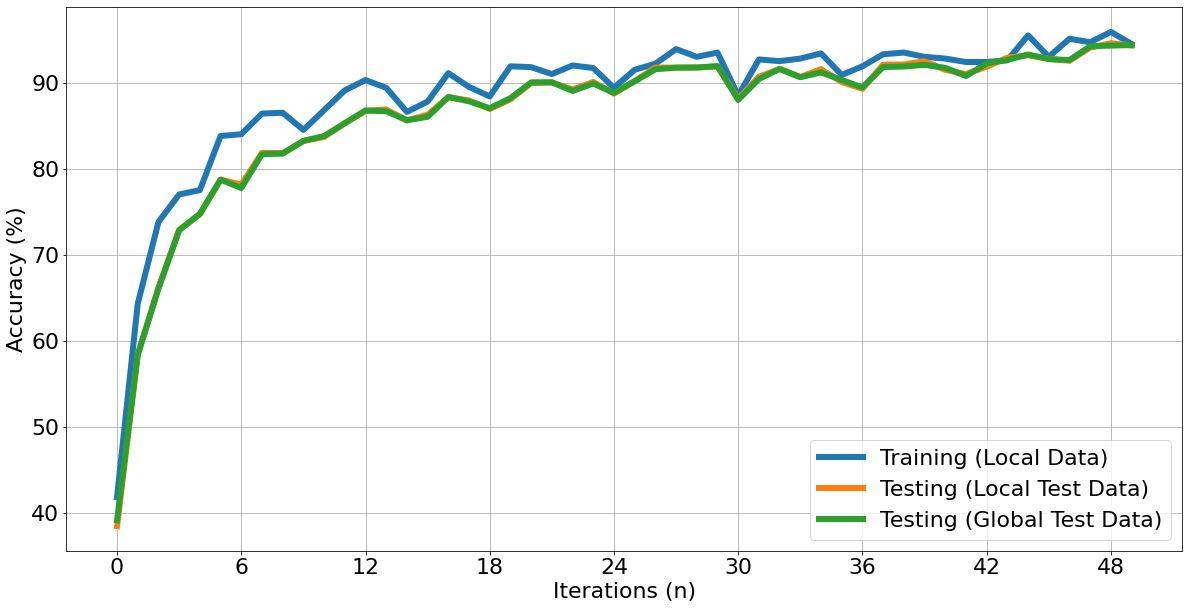

In [44]:
fig2, ax1 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.array(training_round_accuracies_finetune).mean(axis=1)*100, linewidth=6)
plt.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Iterations (n)')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(('Training (Local Data)', 'Testing (Local Test Data)', 'Testing (Global Test Data)'))

